In [11]:
import os

import pandas as pd
import numpy as np

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from keras.layers import Dense, LSTM
from keras.models import Sequential
from sklearn import preprocessing
from tensorflow import keras  # type: ignore
import tensorflow as tf

import matplotlib.pyplot as plt

In [12]:
tf.random.set_seed(42)
np.random.seed(42)
plt.rcParams['figure.figsize'] = [15, 5]

In [13]:
class Data():
    def __init__(self, path, input_size, n_features):
        self.input_size = input_size
        self.n_features = n_features
        self.seg_len = input_size + n_features

        data = pd.read_csv(os.path.join(path, f'ts_real_fake.csv'))
        self.real = data.real.to_numpy()
        self.real = self.normalize(self.real)
        self.real = self.real.tolist()

        self.fake = data.fake.to_numpy()
        self.fake = self.normalize(self.fake)
        self.fake = self.fake.tolist()

        # fake = pd.read_csv(os.path.join(path, f'fake_rolling_6.csv'))
        # self.fake = fake.fake.to_list()

        self.x_train, self.y_train = self.get_train(self.real, 30)
        self.x_test, self.y_test = self.get_test(600)

        self.fake_x_train, self.fake_y_train = self.build_sample_train(
            self.fake, 800)

    def normalize(self, data):
        dataX = np.reshape(data, (-1, 1))
        dataX_scaler = preprocessing.MinMaxScaler().fit_transform(dataX)

        flat_dataX = dataX_scaler.flatten()
        flat_dataX = flat_dataX[flat_dataX > 0]

        return flat_dataX

    def get_train(self, data, n):
        x = []
        y = []
        for i in range(n):
            seg = data[i:i+self.seg_len]
            if len(seg) < self.seg_len:
                break
            x.append(seg[:self.input_size])
            y.append(seg[-self.n_features:])

        return np.asarray(x), np.asarray(y)

    def get_test(self, n):
        x = []
        y = []
        for i in range(n):
            idx = i - n - 4
            seg = self.real[idx:idx+self.seg_len]
            if len(seg) < self.seg_len:
                break
            x.append(seg[:self.input_size])
            y.append(seg[-self.n_features:])

        # return x, y
        return np.asarray(x), np.asarray(y)

    def build_sample_train(self, sample, n):

        x, y = self.get_train(sample, n)

        x = np.vstack([self.x_train, x])
        y = np.concatenate([self.y_train, y])

        # return x, y
        return np.asarray(x), np.asarray(y)

In [14]:
class LSTMValidator():
    def __init__(self, input_size, n_features, dir_path):
        self.input_size = input_size
        self.n_features = n_features

        self.path = dir_path

        self.data_path = os.path.join(self.path, 'data')
        self.data = Data(self.data_path, input_size, n_features)

        # Real model
        model_real = self.prepare_model(self.data.x_train, self.data.y_train)
        predictions_real = model_real.predict(self.data.x_test)

        print('Calculating real MAPE and MSE')
        mape_real = mean_absolute_percentage_error(
            self.data.y_test, predictions_real) * 100
        mse_real = mean_squared_error(self.data.y_test, predictions_real)

        # save real model
        model_real.save(os.path.join(self.path, 'models', f'LSTM_real.h5'))

        # save plot
        y_test_data = self.build_plot_dict(self.data.y_test, 'Target', 'green')
        predictions_real_data = self.build_plot_dict(
            predictions_real, 'Predictions (Real only)', 'blue')
        fig_data = [y_test_data, predictions_real_data]
        self.save_plot(fig_data, 'LSTM_predictions_target_real')

        # Fake model
        model_fake = self.prepare_model(
            self.data.fake_x_train, self.data.fake_y_train)
        predictions_fake = model_fake.predict(self.data.x_test)

        print('Calculating fake MAPE and MSE')
        mape_fake = mean_absolute_percentage_error(
            self.data.y_test, predictions_fake)*100
        mse_fake = mean_squared_error(self.data.y_test, predictions_fake)

        # save fake model
        model_fake.save(os.path.join(self.path, 'models', f'LSTM_fake.h5'))

        # save_plot
        predictions_fake_data = self.build_plot_dict(
            predictions_fake, 'Predictions (Synthetic+Real)', 'red')
        fig_data = [y_test_data, predictions_fake_data]
        self.save_plot(fig_data, 'LSTM_predictions_target_fake')

        # save tri plot (Target vs Real vs Fake)
        fig_data = [y_test_data, predictions_real_data, predictions_fake_data]
        self.save_plot(fig_data, 'LSTM_predictions_target_real_fake')

        # output Mape and MSE
        with open(os.path.join(self.data_path, f'mape_mse.csv'), '+a') as f:
            f.write(f'epoch,mape,mse\n')
            f.write(f'real,{mape_real},{mse_real}\n')
            f.write(f'real+synth,{mape_fake},{mse_fake}\n')

        # save data
        test_set = pd.DataFrame(
            [{'x': x, 'y': y} for x, y in zip(self.data.x_test, self.data.y_test)])
        test_set.to_csv(os.path.join(
            self.data_path, 'target_test_set.csv'), index=False)

        real_pred_flat = np.ndarray.flatten(predictions_real)
        fake_pred_flat = np.ndarray.flatten(predictions_fake)

        predictions = {'real': real_pred_flat, 'real+synth': fake_pred_flat}
        predictions = pd.DataFrame(predictions)
        predictions.to_csv(os.path.join(
            self.data_path, f'LSTM_predictions_real_fake.csv'), index=False)

    def build_custom_model(self):
        model = Sequential()
        model.add(LSTM(150, activation='tanh', input_shape=(
            self.input_size, self.n_features), return_sequences=True))
        model.add(LSTM(50, activation='tanh'))
        model.add(Dense(1, activation='relu'))
        return model

    def prepare_model(self, x_train, y_train):
        keras.backend.clear_session()  # type: ignore
        model = self.build_custom_model()
        model.compile(optimizer='adam', loss='mse')

        model.fit(x_train, y_train, epochs=100,
                  validation_split=0.2, batch_size=32)

        return model

    def build_plot_dict(self, data, label, color):
        fig_data = {
            'data': data,
            'label': label,
            'color': color
        }
        return fig_data

    def save_plot(self, data, plotName):
        plt.clf()
        for f in data:
            f = f.copy()
            data = f.pop('data')
            plt.plot(data, **f, alpha=0.8)
            plt.ylabel('Traffic Load')
            plt.xlabel('Time Period')

        plt.legend()
        plt.savefig(os.path.join(self.path, 'figures',
                    f'{plotName}.png'), dpi=300)

Epoch 1/100
1/1 [==============================] - 4s 4s/step - loss: 0.0058 - val_loss: 0.0014
Epoch 2/100
1/1 [==============================] - 0s 39ms/step - loss: 0.0044 - val_loss: 7.9157e-04
Epoch 3/100
1/1 [==============================] - 0s 38ms/step - loss: 0.0032 - val_loss: 3.6744e-04
Epoch 4/100
1/1 [==============================] - 0s 36ms/step - loss: 0.0022 - val_loss: 1.3350e-04
Epoch 5/100
1/1 [==============================] - 0s 37ms/step - loss: 0.0015 - val_loss: 1.0857e-04
Epoch 6/100
1/1 [==============================] - 0s 34ms/step - loss: 9.5745e-04 - val_loss: 3.0239e-04
Epoch 7/100
1/1 [==============================] - 0s 35ms/step - loss: 7.1648e-04 - val_loss: 6.8968e-04
Epoch 8/100
1/1 [==============================] - 0s 35ms/step - loss: 7.3847e-04 - val_loss: 0.0012
Epoch 9/100
1/1 [==============================] - 0s 33ms/step - loss: 9.4823e-04 - val_loss: 0.0016
Epoch 10/100
1/1 [==============================] - 0s 34ms/step - loss: 0.0012 

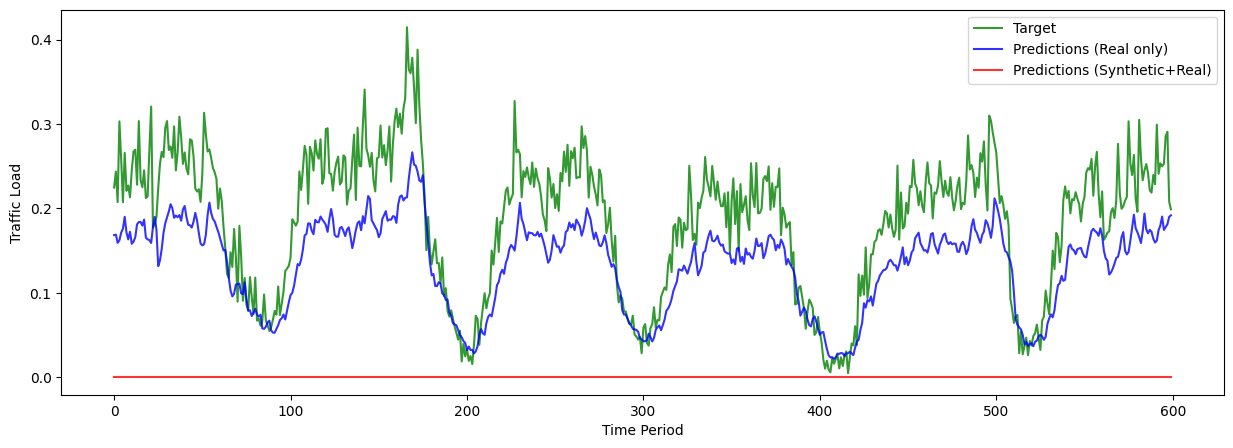

In [15]:
p = LSTMValidator(3, 1, 'out/ita_teleco/')